In [568]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt

# Fixed variables of density matrix
gamma = 0.8
# t = 1
# t = 2*0.00000000000000001
t = 0.677

# == Test function ==
Hadamard = np.array([ [1,1], [1,-1] ])/np.sqrt(2)

def rho_after_2nd(phi):
    rho = np.array([ [1, np.exp(1.j * phi - t)], [np.exp(-1.j * phi - t), 1] ]) / 2
    
    return Hadamard @ rho @ Hadamard.conj().T


# Same as rho_ps
def rho_after_kraus(rho):
    k = np.array([ [np.sqrt(1-gamma), 0], [0, 1] ])
    
    rho_ps = (k @ rho @ k.conj().T) / (np.trace(k @ k.conj().T @ rho))
    
    return rho_ps


def classical_fisher_information(rho):
    
  tr = np.trace(rho)
  s = np.linalg.eigvalsh(rho)
  return (1 / tr) * np.sum((s / (s - 1))**2)


def CFI(phi):
    return (-4 * (gamma-1) * np.exp(2 * t) * np.sin(phi)**2) / ((np.exp(2 * t)-np.cos(phi)**2)*(gamma * np.cos(phi)+(gamma-2) * np.exp(2 * t))**2)


# == Calculating ==
def rho_ps(phi):

	rho_ps = np.array([ [(gamma - 1 )*(np.exp(t) + np.cos(phi)), 1.j*np.sqrt(1-gamma)*np.sin(phi) ], [-1.j*np.sqrt(1-gamma)*np.sin(phi), np.cos(phi) - np.exp(t)] ]) / (gamma * np.cos(phi) + (gamma - 2) * np.exp(t))
	return rho_ps


def get_state(phi):
    rho_temp = rho_ps(phi)
    
    eig_val, eig_vec = np.linalg.eig(rho_temp)
    index = np.argmax(eig_val)
    
    eigen_vectors = eig_vec[:, index]
    
    return eigen_vectors 

In [569]:
np.isclose(rho_after_kraus(rho_after_2nd(np.pi)), rho_ps(np.pi))

tensor([[ True,  True],
        [ True,  True]], requires_grad=True)

In [570]:
mem_1, mem_2 = np.linalg.eig(rho_ps(np.pi))

print(mem_1)
print()
print(mem_2)

get_state(np.pi)

[0.06123342-0.j 0.93876658+0.j]

[[1.+0.00000000e+00j 0.-1.97406369e-17j]
 [0.+0.00000000e+00j 1.+0.00000000e+00j]]


tensor([0.-1.97406369e-17j, 1.+0.00000000e+00j], requires_grad=True)

In [571]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def circuit(phi):
    qml.QubitStateVector(get_state(phi), wires = 0)
    
    return qml.probs()

In [572]:
circuit(np.pi)

tensor([3.89692745e-34, 1.00000000e+00], requires_grad=True)

In [573]:
# qml
para = np.array([2])
print(qml.qinfo.classical_fisher(circuit)(para[0]))

# equ
print(CFI(np.pi))
# print(classical_fisher_information( rho_ps(np.pi) ))
# CFI(np.pi)

# np.isclose( classical_fisher_information(rho_ps(np.pi)), CFI(np.pi) ) 

[[0.11183128]]
5.450537979153142e-34


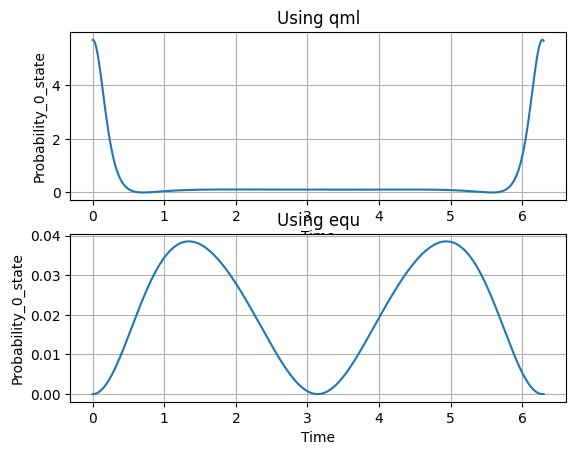

In [574]:
#  == Plot for CFI ==
N = 1000
tau_CFI = np.linspace(-0.001, 6.3, N)

CFI_numpy = np.zeros(N)
CFI_equ = np.zeros(N)


# CFI -> Approcach with array index
for i in range(len(tau_CFI)):
    CFI_numpy[i] = (qml.qinfo.classical_fisher(circuit)(tau_CFI[i]))
    # Casting to numpy array without gradient
    CFI_numpy[i] = round((CFI_numpy[i]).numpy(), 10)
    
    CFI_equ[i] = CFI(tau_CFI[i])


plt.subplot(211)
plt.plot(tau_CFI, CFI_numpy)
plt.title('Using qml')
plt.xlabel('Time')
plt.ylabel('Probability_0_state')
# plt.legend()
plt.grid()



plt.subplot(212)
plt.plot(tau_CFI, CFI_equ)
plt.title('Using equ')
plt.xlabel('Time')
plt.ylabel('Probability_0_state')
# plt.legend()
plt.grid()

In [575]:
tau_CFI

tensor([-1.00000000e-03,  5.30730731e-03,  1.16146146e-02,
         1.79219219e-02,  2.42292292e-02,  3.05365365e-02,
         3.68438438e-02,  4.31511512e-02,  4.94584585e-02,
         5.57657658e-02,  6.20730731e-02,  6.83803804e-02,
         7.46876877e-02,  8.09949950e-02,  8.73023023e-02,
         9.36096096e-02,  9.99169169e-02,  1.06224224e-01,
         1.12531532e-01,  1.18838839e-01,  1.25146146e-01,
         1.31453453e-01,  1.37760761e-01,  1.44068068e-01,
         1.50375375e-01,  1.56682683e-01,  1.62989990e-01,
         1.69297297e-01,  1.75604605e-01,  1.81911912e-01,
         1.88219219e-01,  1.94526527e-01,  2.00833834e-01,
         2.07141141e-01,  2.13448448e-01,  2.19755756e-01,
         2.26063063e-01,  2.32370370e-01,  2.38677678e-01,
         2.44984985e-01,  2.51292292e-01,  2.57599600e-01,
         2.63906907e-01,  2.70214214e-01,  2.76521522e-01,
         2.82828829e-01,  2.89136136e-01,  2.95443443e-01,
         3.01750751e-01,  3.08058058e-01,  3.14365365e-0

In [576]:
# Check for the CFI
var = np.array([3])
CFI_temp = (qml.qinfo.classical_fisher(circuit)(var[0]))

    # Casting to numpy array without gradient
# CFI_temp = round((CFI_temp).numpy(), 5)

# np.isclose(CFI(3), CFI_temp)

# np.isclose(CFI_temp[0], CFI(3))

print('By_func: ',CFI(3), 'By_qml:', CFI_temp[0])

By_func:  0.0007208952937824371 By_qml: [0.10412093]
